# Load Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import re
import requests,io

import astroalign

from astropy.io import fits
from astropy.stats import sigma_clipped_stats,gaussian_sigma_to_fwhm, SigmaClip
from astropy.table import QTable, Table
from astropy.utils.exceptions import AstropyDeprecationWarning


from photutils.background import LocalBackground, MMMBackground,Background2D,MedianBackground
from photutils.detection import DAOStarFinder
from photutils.psf import PSFPhotometry, IterativePSFPhotometry, IntegratedGaussianPRF,prepare_psf_model, IterativelySubtractedPSFPhotometry, DAOGroup, SourceGrouper
from shapely.geometry import LineString, Point
from scipy import interpolate

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from matplotlib.colors import LogNorm

# Load the reduced data

In [2]:
data_path = 'data/reduced'

In [3]:
data = {}
data["M29B"] = np.load(f'{data_path}/M29B.npy')
data["M29V"] = np.load(f'{data_path}/M29G.npy')

In [4]:
for key, image in data.items():
    print(image.shape)

(1024, 1536)
(1024, 1536)


In [5]:
error = {}
error["M29B"] = np.load(f'{data_path}/M29B_error.npy')
error["M29V"] = np.load(f'{data_path}/M29G_error.npy')[0]

# Background Estimation


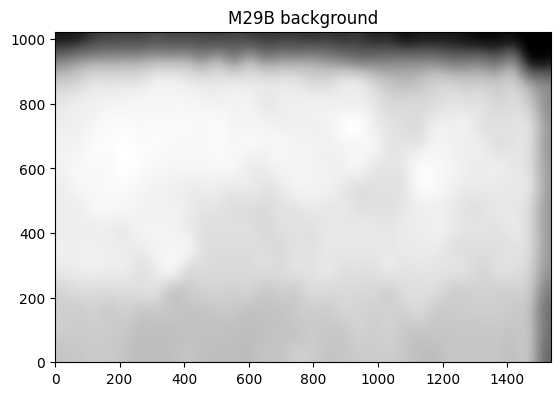

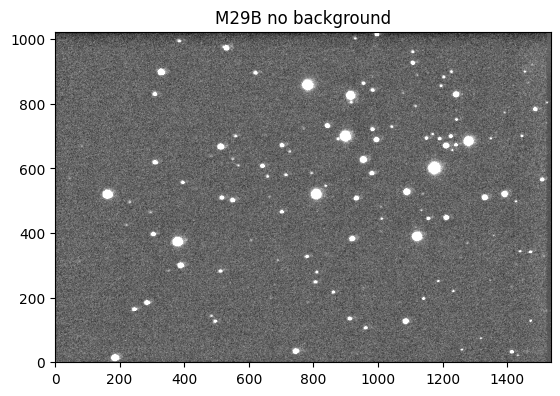

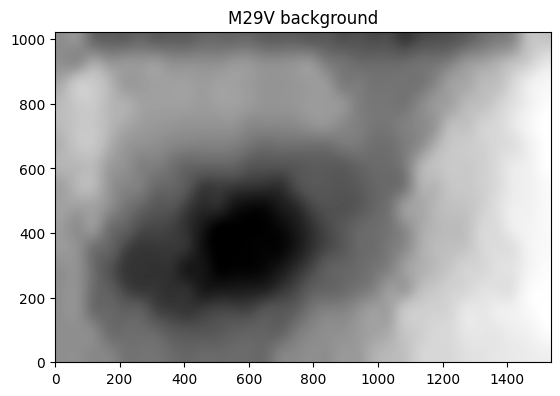

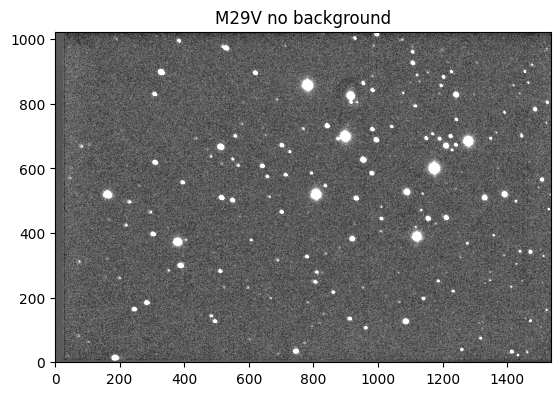

In [6]:
bkgs={}
bkg_uncs = {}
for key, image in data.items():
    sigma_clip = SigmaClip(sigma=3.0)
    bkg_estimator = MedianBackground()
    bkg = Background2D(image,
                       (64,48), #they say it works better if data is covered by int nb of boxes
                       filter_size=(3,3),sigma_clip=sigma_clip,
                    bkg_estimator=bkg_estimator)
    bkgs[key] = bkg.background
    bkg_uncs[key] = bkg.background_rms
    plt.title(f'{key} background')
    plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
    plt.show()

    lo,up= np.percentile(image-bkg.background,1),np.percentile(image-bkg.background,99)
    plt.imshow(image-bkg.background, cmap='gray', origin='lower', clim=(lo,up))
    plt.title(f'{key} no background')
    plt.show()

    data[key] = image - bkg.background




# Get 2D FWHM

Found 90 stars in image M29B


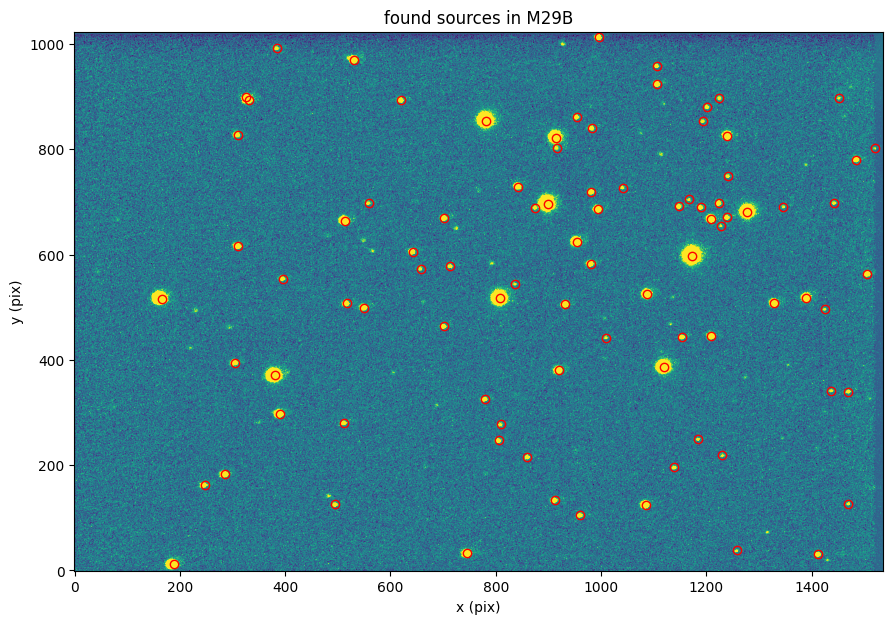

     x-FWHM 5.289131542312301+/-0.13607480433694988 (pix) for this M29B 
     y-FWHM 6.059529251279225+/-0.16848856733894454 (pix) for this M29B 
     FWHM 5.674330396795764+/-0.15109862742135563 (pix) for this M29B 
Found 142 stars in image M29V


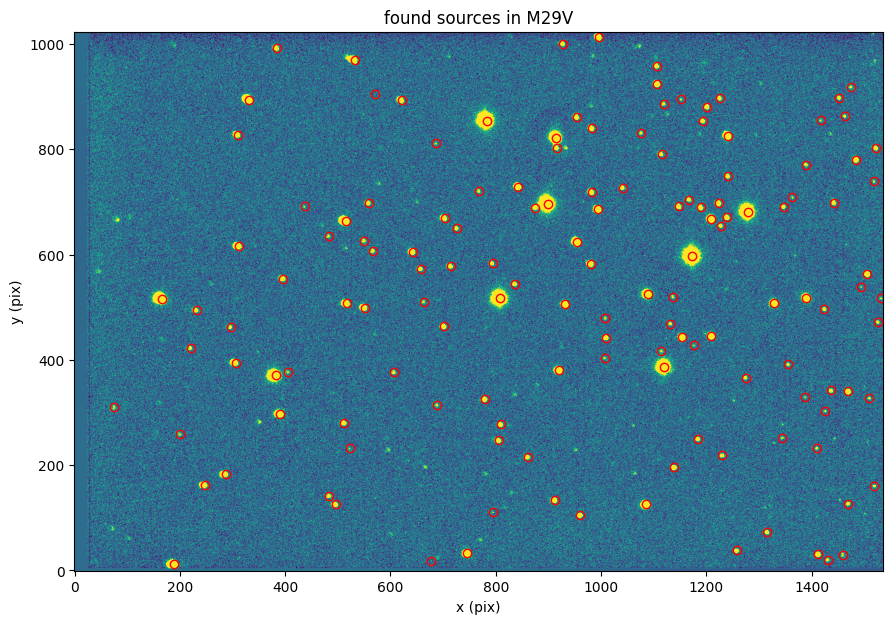

     x-FWHM 5.63515967707049+/-0.25766798797460627 (pix) for this M29V 
     y-FWHM 4.919274796716662+/-0.30736998551824285 (pix) for this M29V 
     FWHM 5.2832454132910724+/-0.24170618626175716 (pix) for this M29V 


In [7]:
xfwhms = {}
yfwhms = {}
fwhms = {}
for key, image in data.items():
    mean, median, std = sigma_clipped_stats(image,sigma=3.0,maxiters=50)
    ## Find stars
    daofind = DAOStarFinder(fwhm=5.5, threshold=6.0*std, exclude_border= True)
    sources = daofind(image - median)
    print(f"Found {len(sources)} stars in image {key}")

    #Plot stars found
    fig = plt.figure(figsize=(12,7))
    l1 = np.percentile(image[np.isfinite(image)].flatten(), 1)
    l2 = np.percentile(image[np.isfinite(image)].flatten(), 99)
    plt.imshow(image,clim=(l1,l2),origin='lower')
    plt.plot(sources["xcentroid"],sources["ycentroid"],'or',mfc='none')
    plt.title(f"found sources in {key}")
    plt.xlabel("x (pix)")
    plt.ylabel("y (pix)")
    plt.show()

    ## Take nbright brightest stars 
    nbright = 5
    brightest = np.argsort(sources['flux'])[::-1][0:nbright]
    brsources = sources[brightest]

    ##########
    #get fwhm
    rmax = 25
    (ny,nx) = np.shape(image)
    from astropy.modeling import models,fitting
    fit_g = fitting.LevMarLSQFitter()
    allxfwhm, allyfwhm = np.zeros(len(brsources)),np.zeros(len(brsources))
    allfwhm,alltheta = np.zeros(len(brsources)),np.zeros(len(brsources))
    for i,src in enumerate(brsources):
        if int(src['ycentroid']) > rmax and int(src['ycentroid']) < ny-rmax and \
            int(src['xcentroid']) > rmax and int(src['xcentroid']) < nx-rmax:
            img = image[int(src['ycentroid'])-rmax:int(src['ycentroid'])+rmax,
                        int(src['xcentroid'])-rmax:int(src['xcentroid'])+rmax]
            subx,suby = np.indices(img.shape) # instead of meshgrid
            p_init = models.Gaussian2D(amplitude=np.max(img),x_mean=rmax,y_mean=rmax,x_stddev=1.0,y_stddev=1.0)
            fitgauss = fit_g(p_init, subx, suby, img - np.min(img))
            allxfwhm[i] = np.abs(fitgauss.x_stddev.value)
            allyfwhm[i] = np.abs(fitgauss.y_stddev.value)
            allfwhm[i] = 0.5*(allxfwhm[i]+allyfwhm[i])
            alltheta[i] = fitgauss.theta.value
    xfwhm,yfwhm = np.median(allxfwhm)*gaussian_sigma_to_fwhm,np.median(allyfwhm)*gaussian_sigma_to_fwhm
    fwhm = np.median(allfwhm)*gaussian_sigma_to_fwhm
    sigfwhm, sigxfwhm, sigyfwhm = np.std(allfwhm), np.std(allxfwhm), np.std(allyfwhm)
    medtheta = np.median(alltheta)
    print(f"     x-FWHM {xfwhm}+/-{sigxfwhm} (pix) for this {key} ")
    print(f"     y-FWHM {yfwhm}+/-{sigyfwhm} (pix) for this {key} ")
    print(f"     FWHM {fwhm}+/-{sigfwhm} (pix) for this {key} ")

    fwhms[key] = fwhm
    xfwhms[key] = xfwhm
    yfwhms[key] = yfwhm


# 2d gaussians

In [8]:
twodgauss = {}
psf_models = {}
for key, image in data.items():
    twodgauss[key] =  models.Gaussian2D(x_stddev=xfwhms[key]/gaussian_sigma_to_fwhm,
                                        y_stddev=yfwhms[key]/gaussian_sigma_to_fwhm,
                                        )
    
    #twodgauss[key].xname = 'x'
    #twodgauss[key].yname = 'y'
    #twodgauss[key].fluxname = 'amplitude'

    psf_models[key] = prepare_psf_model(twodgauss[key],xname='x_mean',yname='y_mean',fluxname='amplitude')


    

# Find point sources more accuretly with FWHM
more stars found this way:)

In [9]:
fwhms

{'M29B': 5.674330396795764, 'M29V': 5.2832454132910724}

Found 103 stars in image M29B


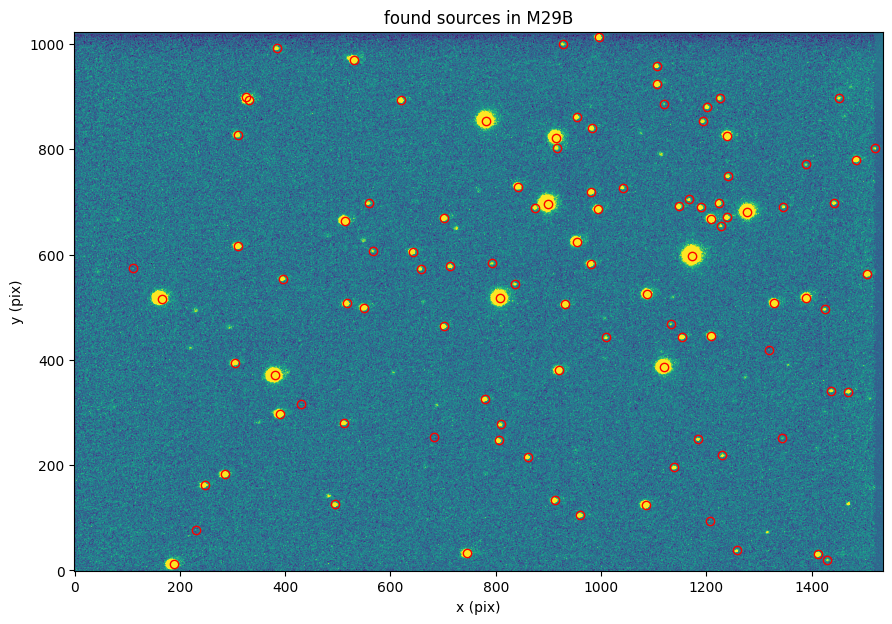

Found 188 stars in image M29V


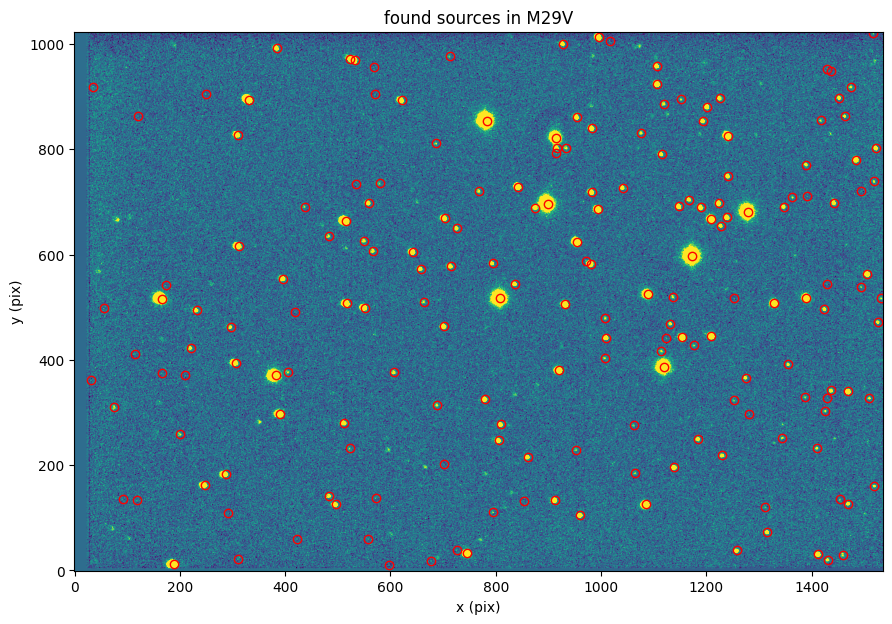

In [10]:
x_inits = {}
y_inits = {}

daofinds = {}

for key, image in data.items():

    mean, median, std = sigma_clipped_stats(image,sigma=3.0,maxiters=150)
    ## Find stars
    daofind = DAOStarFinder(fwhm=fwhms[key], threshold=5.0*std, exclude_border= True)
    sources = daofind(image - median)
    print(f"Found {len(sources)} stars in image {key}")

    daofinds[key]=daofind

    #Plot stars found
    fig = plt.figure(figsize=(12,7))
    l1 = np.percentile(image[np.isfinite(image)].flatten(), 1)
    l2 = np.percentile(image[np.isfinite(image)].flatten(), 99)
    plt.imshow(image,clim=(l1,l2),origin='lower')
    plt.plot(sources["xcentroid"],sources["ycentroid"],'or',mfc='none')
    plt.title(f"found sources in {key}")
    plt.xlabel("x (pix)")
    plt.ylabel("y (pix)")
    plt.show()

    ## Take nbright brightest stars and save
    nbright = 5
    brightest = np.argsort(sources['flux'])[::-1]#[0:nbright]
    brsources = sources[brightest]

    x_inits[key] = brsources['xcentroid']
    y_inits[key] = brsources['ycentroid']



# Iterative PSF Photometry :)

In [40]:
phots = {}

for key, image in data.items():

    group = SourceGrouper(fwhms[key])
    PSF = PSFPhotometry(
        grouper=group ,     
        psf_model=IntegratedGaussianPRF(sigma=fwhms[key]/gaussian_sigma_to_fwhm),
        finder=daofinds[key],
        fit_shape=(3,3), #play with this, this may be small
        aperture_radius=5 ,#play with this as well
        fitter_maxiters=500
    )
    init_params = QTable()
    init_params['x'] = x_inits[key]
    init_params['y'] = y_inits[key]

    phots[key] = PSF(image, 
                        init_params = init_params,
                        error=np.sqrt(np.square(bkg_uncs[key])+np.square(error[key])), 
                )

## See found stars 

<Figure size 640x480 with 0 Axes>

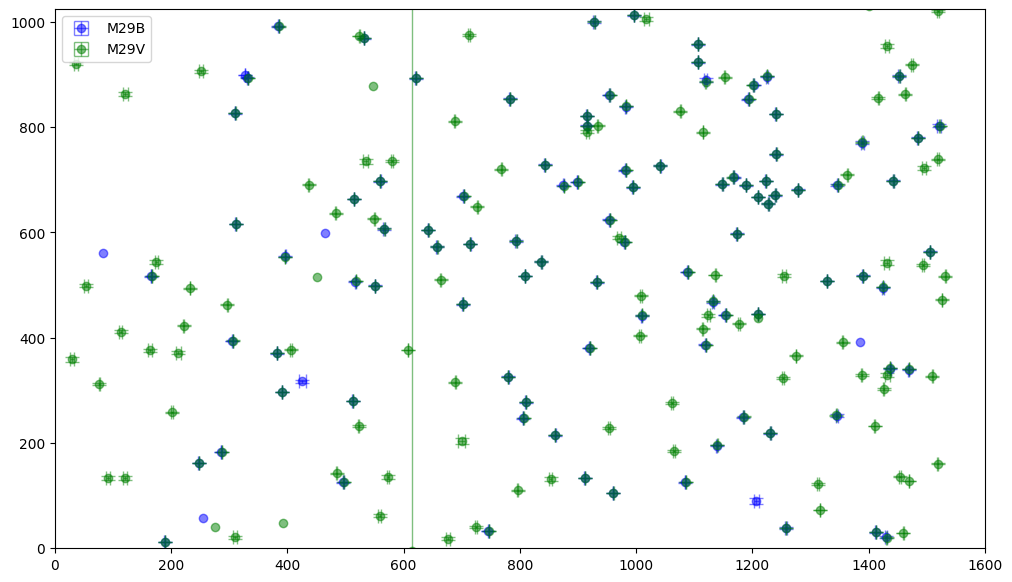

In [41]:

plt.clf()
fig = plt.figure(figsize=(12,7))
#plt.scatter(phots['M29B']['x_fit'],phots['M29B']['y_fit'], marker='o', c='blue', alpha=0.5)
#plt.scatter(phots['M29V']['x_fit'],phots['M29V']['y_fit'], marker='o', c='green',alpha=0.5)

plt.errorbar(x=phots['M29B']['x_fit'],y=phots['M29B']['y_fit'],
             xerr=phots['M29B']['x_err'],
             yerr=phots['M29B']['y_err'],fmt='o', ecolor='blue', elinewidth=1, capsize=5,c='blue',label="M29B",alpha=0.5
              )
plt.errorbar(x=phots['M29V']['x_fit'],y=phots['M29V']['y_fit'],
             xerr=phots['M29V']['x_err'],
             yerr=phots['M29V']['y_err'],fmt='o', ecolor='green', elinewidth=1, capsize=5,c='green',label="M29V",alpha=0.5
              )
plt.xlim([0,1600])
plt.ylim([0,1024])
plt.legend()

plt.show()

## Create dataframe for both Filters

In [42]:
m29b = phots['M29B'].to_pandas()
m29v = phots['M29V'].to_pandas()

In [43]:
# function to filter out some bad points

def clean_df(data, n=0):
    # Drop rows with missing values
    df = data.dropna(inplace=False)

    # Apply the initial filtering conditions
    cond = (df['flags'] == 0) & (df['x_fit'] > 0) & (df['x_fit'] < 1536) & (df['y_fit'] > 0) & (df['y_fit'] < 1024)
    filtered_df = df[cond].copy()

    # Keep only nth lines with the highest 'flux_fit'
    if n > 0:
        filtered_df = filtered_df.nlargest(n, 'flux_fit')

    return filtered_df




In [44]:
print(f"B : {m29b.shape}")
print(f"V : {m29v.shape}")


B : (103, 17)
V : (188, 17)


In [45]:
m29b = clean_df(m29b)
m29v = clean_df(m29v)
print(f"B : {m29b.shape}")
print(f"V : {m29v.shape}")

B : (99, 17)
V : (179, 17)


In [46]:
matched_indexes_b = []
matched_indexes_v = []

margin = 1 #2 pixeis

dt_B = 45
dt_V = 70

m29 = pd.DataFrame(columns = ["Bflux", "Vflux","Bflux_err",'Vflux_err'])
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    for i_m29v, row_m29v in m29v.iterrows():
        for i_m29b, row_m29b in m29b.iterrows():
            if abs(row_m29v['x_fit'] - row_m29b['x_fit']) < margin and abs(row_m29b['y_fit'] - row_m29v['y_fit']) < margin:

                m29 = m29.append({
                    'Bflux':row_m29b['flux_fit']/dt_B,
                    'Vflux':row_m29v['flux_fit']/dt_V,
                    'Bflux_err':row_m29b['flux_err']/dt_B,
                    'Vflux_err':row_m29v['flux_err']/dt_V
                                }, 
                                ignore_index= True)

                if (i_m29v in matched_indexes_v) or (i_m29b in matched_indexes_b):
                    print(f"Something's wrong {i_m29v} {i_m29b}")
                matched_indexes_b.append(i_m29b)
                matched_indexes_v.append(i_m29v)





In [47]:
m29.shape

(82, 4)

# HR Diagram Relative Magnitudes

<Figure size 640x480 with 0 Axes>

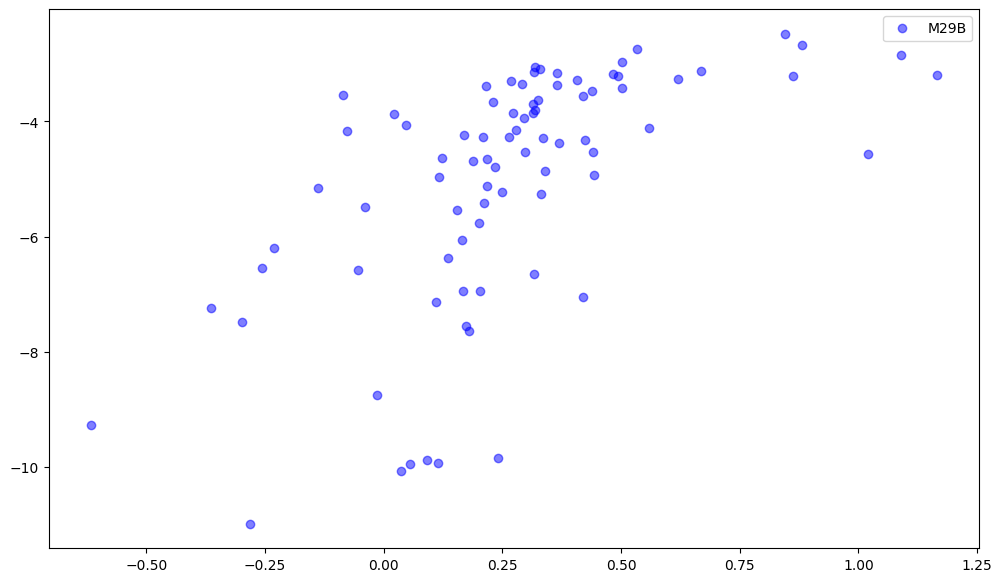

In [49]:

plt.clf()
fig = plt.figure(figsize=(12,7))

plt.errorbar(y=-2.5*np.log10(m29.Bflux),x=-2.5*np.log10(m29.Bflux/m29.Vflux),
             #xerr=phots['M29B']['x_err'],
             #yerr=phots['M29B']['y_err'],
             fmt='o', ecolor='blue', elinewidth=1, capsize=5,c='blue',label="M29B",alpha=0.5
              )

plt.legend()

plt.show()

In [50]:
def calc_m (flux):
    return -2.5 * np.log10(flux)

def calc_m_err(flux, flux_err):
    return abs(-2.5/(flux*np.log(10))*flux_err)

def calc_M (m,d):
    return m - 5*np.log10(d) + 5

def calc_M_err (m_err, d , d_err):
    return np.sqrt(m_err **2 + ((-5/(d *np.log(10)))*d_err)**2 )
    


# Correct to Distance + Standard Star

In [51]:
#Standard star hip100108
#https://simbad.cds.unistra.fr/simbad/sim-ref?bibcode=2020yCat.1350....0G
d_StStar=  59.791
d_StStar_err=0.1312 
M_abs_StStar_B_true = 5.64
M_abs_StStar_V_true = 5.58

StStar_Bflux = 330820.5932283057
StStar_Bflux_err= 26027.889649890487

StStar_Vflux = 706937.6199424627
StStar_Vflux_err = 73.57302933502534

m_StStar_B = calc_m(StStar_Bflux) #+instrumental zero point
m_StStar_B_err = calc_m_err(flux=StStar_Bflux, flux_err=StStar_Bflux_err)

m_StStar_V = calc_m(StStar_Vflux) #+instrumental zero point
m_StStar_V_err = calc_m_err(flux=StStar_Vflux, flux_err=StStar_Vflux_err)

print(f"Standard Star mB = {m_StStar_B} +- {m_StStar_B_err}")
print(f"Standard Star mV = {m_StStar_V} +- {m_StStar_V_err}")



Standard Star mB = -13.798981340223111 +- 0.08542219772525807
Standard Star mV = -14.623452733537508 +- 0.00011299568645005823


In [52]:
M_abs_StStar_B = calc_M(m=m_StStar_B,d=d_StStar)
M_abs_StStar_B_err = calc_M_err(m_err=m_StStar_B_err,d=d_StStar,d_err=d_StStar_err)

M_abs_StStar_V = calc_M(m=m_StStar_V,d=d_StStar)
M_abs_StStar_V_err = calc_M_err(m_err=m_StStar_V_err,d=d_StStar,d_err=d_StStar_err)

print(f"Standard Star MB = {M_abs_StStar_B} +- {M_abs_StStar_B_err}")
print(f"Standard Star MV = {M_abs_StStar_V} +- {M_abs_StStar_V_err}")



Standard Star MB = -17.6821604253411 +- 0.08555498807134229
Standard Star MV = -18.506631818655496 +- 0.004766223630883611


In [53]:
inst_calib_B = M_abs_StStar_B_true - M_abs_StStar_B
inst_calib_V = M_abs_StStar_V_true - M_abs_StStar_V

inst_calib_B_err = M_abs_StStar_B_err
inst_calib_V_err = M_abs_StStar_V_err

In [54]:
m29["mB"] = calc_m(flux=m29["Bflux"])
m29["mB_err"] = calc_m_err(flux=m29["Bflux"],flux_err=m29["Bflux_err"])

m29["mV"] = calc_m(flux=m29["Vflux"])
m29["mV_err"] = calc_m_err(flux=m29["Vflux"],flux_err=m29["Vflux_err"])




In [55]:
#https://simbad.cds.unistra.fr/simbad/sim-ref?bibcode=2021MNRAS.504..356D
d= 1785
d_err=107

MB_uncalib = calc_M(m=m29["mB"],d=d)
MB_uncalib_err = calc_M_err(m_err=m29["mB_err"],d=d,d_err=d_err)

MV_uncalib = calc_M(m=m29["mV"],d=d)
MV_uncalib_err = calc_M_err(m_err=m29["mV_err"],d=d,d_err=d_err)


In [56]:
m29["MB"] = inst_calib_B + MB_uncalib
m29["MB_err"] = np.sqrt( inst_calib_B_err**2 + MB_uncalib_err**2 )

m29["MV"] = inst_calib_V + MV_uncalib
m29["MV_err"] = np.sqrt( inst_calib_V_err**2 + MV_uncalib_err**2 )

In [57]:
m29["BV"] = m29["mB"] - m29["mV"]
m29["BV_err"] = np.sqrt( m29["MB_err"]**2 + m29["MV_err"]**2  )

<Figure size 640x480 with 0 Axes>

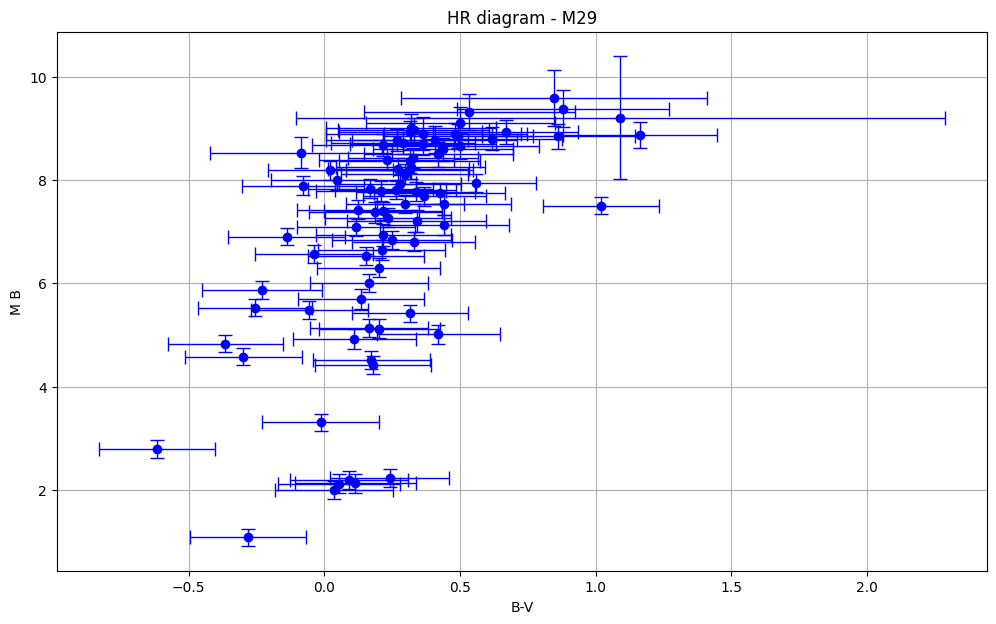

In [58]:
plt.clf()
fig = plt.figure(figsize=(12,7))
plt.errorbar(
    x=m29["BV"],
    y=m29["MB"],
    xerr=m29["BV_err"],
    yerr=m29["MB_err"],
    fmt='o', ecolor='blue', elinewidth=1, capsize=5,c='blue'
)
plt.xlabel('B-V')
plt.ylabel('M B')

plt.title("HR diagram - M29")
plt.grid(True)
plt.show()

In [59]:
m29["BV"] = -2.5*np.log10(m29["Bflux"]/m29["Vflux"])

m29["BV_err"] = np.sqrt( np.square( calc_m_err(m29["Bflux"],m29["Bflux_err"] ))  +  np.square( calc_m_err(m29["Vflux"],m29["Vflux_err"] )) )

# HR Diagram

<Figure size 640x480 with 0 Axes>

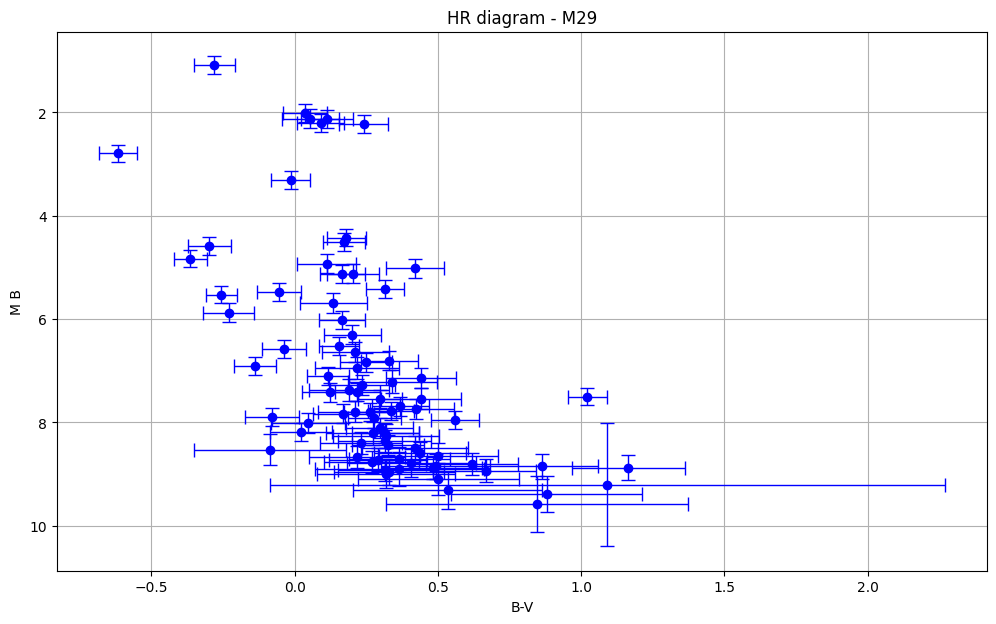

In [60]:
plt.clf()
fig = plt.figure(figsize=(12,7))
plt.errorbar(
    x=m29["BV"],
    y=m29["MB"],
    xerr=m29["BV_err"],
    yerr=m29["MB_err"],
    fmt='o', ecolor='blue', elinewidth=1, capsize=5,c='blue'
)
plt.xlabel('B-V')
plt.ylabel('M B')

plt.gca().invert_yaxis()

plt.title("HR diagram - M29")
plt.grid(True)
plt.show()

## Remove points w/ bigger uncertainties

<Figure size 640x480 with 0 Axes>

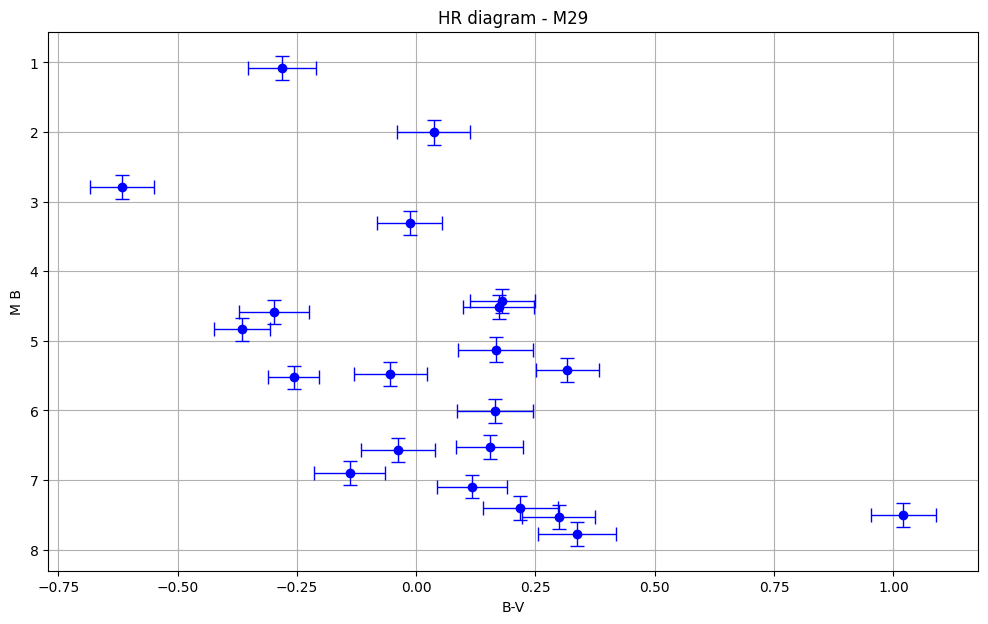

In [31]:

acc = 0.175
#condition to remove data point
m29 = m29[(m29['BV_err'] < acc) & (m29['MB_err'] < acc)]

plt.clf()
fig = plt.figure(figsize=(12,7))
plt.errorbar(
    x=m29["BV"],
    y=m29["MB"],
    xerr=m29["BV_err"],
    yerr=m29["MB_err"],
    fmt='o', ecolor='blue', elinewidth=1, capsize=5,c='blue'
)
plt.xlabel('B-V')
plt.ylabel('M B')

plt.gca().invert_yaxis()

plt.title("HR diagram - M29")
plt.grid(True)
plt.show()


# Isochrone Fitting

In [66]:
#Read the models
#Important: Open the model file (in any text editor) and remove the # at the beginning of the line 13 (names of the columns)
#Otherwise python won't know the column names and will call them col1, col2 etc.
isochrones = Table.read('data/models/m29_isochrones_fit_5a13.dat', format='ascii')
print(isochrones.columns)

#Let's see which ages we have in the model file
logages=np.unique(isochrones['logAge']) #find the unique age entries
ages=np.unique(10**isochrones['logAge']/1e6) #in Myrs
print(f"data from {np.min(ages)} to {np.max(ages)} Myrs")

<TableColumns names=('Zini','MH','logAge','Mini','int_IMF','Mass','logL','logTe','logg','label','McoreTP','C_O','period0','period1','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo','Cexcess','Z','mbolmag','Umag','Bmag','Vmag','Rmag','Imag','Jmag','Hmag','Kmag')>
data from 4.99999995007974 to 29.00013369054067 Myrs


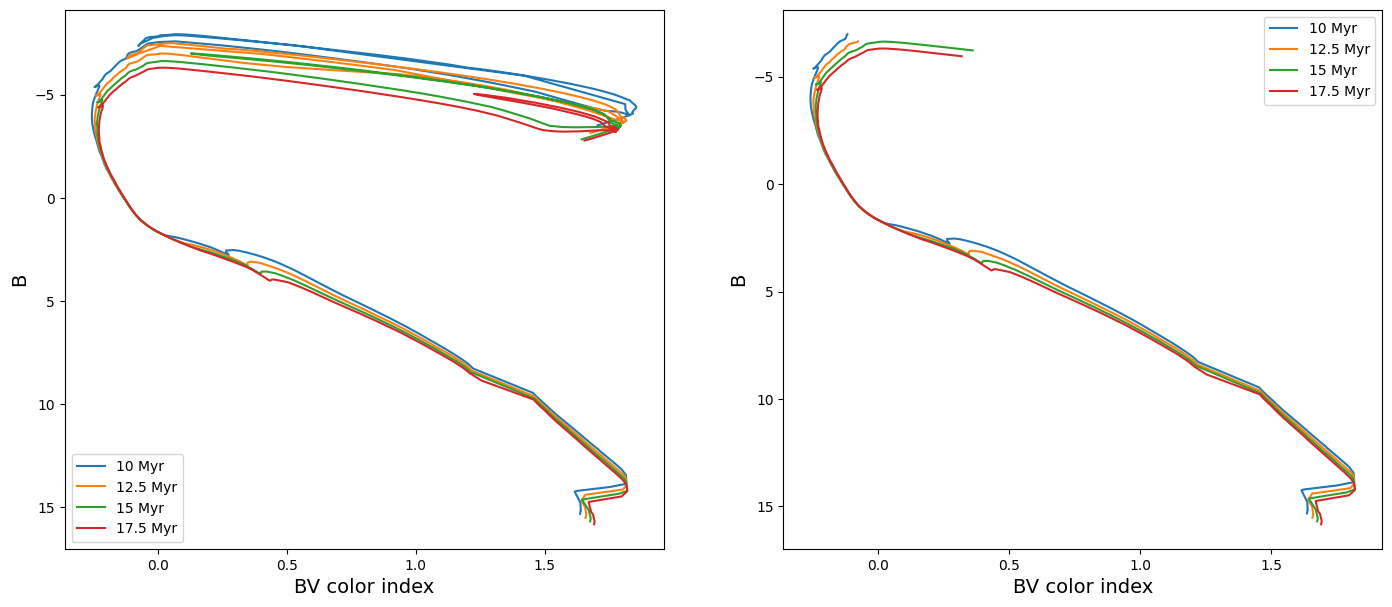

In [67]:
#you can select the isochrone with some particular age
age_1 = isochrones['logAge'] == 7 
age_2 = isochrones['logAge'] == 7.09691 
age_3 = isochrones['logAge'] == 7.17609 
age_4 = isochrones['logAge'] == 7.24304 

fig,[ax1,ax2] = plt.subplots(nrows=1,ncols=2,figsize=(17,7))
ax1.plot(isochrones['Bmag'][age_1] - isochrones['Vmag'][age_1], isochrones['Bmag'][age_1],label='10 Myr')
ax1.plot(isochrones['Bmag'][age_2] - isochrones['Vmag'][age_2], isochrones['Bmag'][age_2],label='12.5 Myr')
ax1.plot(isochrones['Bmag'][age_3] - isochrones['Vmag'][age_3], isochrones['Bmag'][age_3],label='15 Myr')
ax1.plot(isochrones['Bmag'][age_4] - isochrones['Vmag'][age_4], isochrones['Bmag'][age_4],label='17.5 Myr')
ax1.invert_yaxis()
ax1.set_xlabel('BV color index',fontsize=14)
ax1.set_ylabel('B',fontsize=14)
ax1.legend()

#We can cut off the more evolved stages
N=200
ax2.plot(isochrones['Bmag'][age_1][0:N] - isochrones['Vmag'][age_1][0:N], isochrones['Bmag'][age_1][0:N],label='10 Myr')
ax2.plot(isochrones['Bmag'][age_2][0:N] - isochrones['Vmag'][age_2][0:N], isochrones['Bmag'][age_2][0:N],label='12.5 Myr')
ax2.plot(isochrones['Bmag'][age_3][0:N] - isochrones['Vmag'][age_3][0:N], isochrones['Bmag'][age_3][0:N],label='15 Myr')
ax2.plot(isochrones['Bmag'][age_4][0:N] - isochrones['Vmag'][age_4][0:N], isochrones['Bmag'][age_4][0:N],label='17.5 Myr')
ax2.invert_yaxis()
ax2.set_xlabel('BV color index',fontsize=14)
ax2.set_ylabel('B',fontsize=14)
ax2.legend()

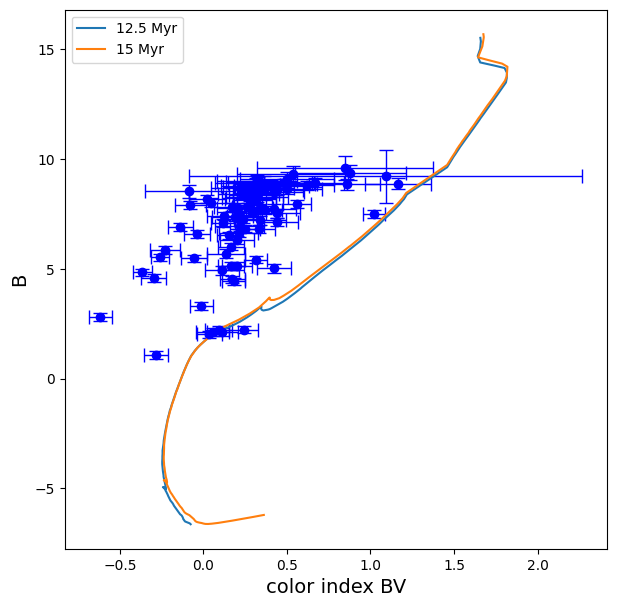

In [68]:
#Let's now plot a model on top of our data, just approximately
fig = plt.figure(figsize=(7,7))
plt.errorbar(
    x=m29["BV"],
    y=m29["MB"],
    xerr=m29["BV_err"],
    yerr=m29["MB_err"],
    fmt='o', ecolor='blue', elinewidth=1, capsize=5,c='blue'
)
#plt.ylim(21,2)
plt.xlabel('color index BV',fontsize=14)
plt.ylabel('B',fontsize=14)

#Important: isochrones are given in absolute magnitudes, while the data come in apparent
#median_parallax=np.nanmedian(data['parallax'])
#dist=1000/median_parallax #Important: This distance here is just for demonstration (approximate), we will use a different method o determine it
#DM=5*np.log10(dist)-5 #distance modulus
#print('distance modulus:',DM)
plt.plot(isochrones['Bmag'][age_2][0:N] - isochrones['Vmag'][age_2][0:N], isochrones['Bmag'][age_2][0:N],label='12.5 Myr')
plt.plot(isochrones['Bmag'][age_3][0:N] - isochrones['Vmag'][age_3][0:N], isochrones['Bmag'][age_3][0:N],label='15 Myr')
plt.legend()
#print(dist)

## 2D fit on age and d (using m app)

In [74]:
#all the ages that we will test
ages=np.unique(isochrones['logAge'])

#distance
dmin,dmax,step=0.0,1000,100
distances = np.arange(dmin,dmax,step)

#define an array to save the root-mean-square deviation values
rmsd=np.zeros(shape=(len(ages),len(distances)))
for i in range(len(ages)):
    age=ages[i]
    for j in range(len(distances)):

        ## model
        distance=distances[j]
        if distance == 0:
            DM = 0
        else:
            DM=5*np.log10(distance)-5
        

        isochrone=isochrones[isochrones['logAge'] == age][0:N]
        col_iso = isochrone['Bmag'] - isochrone['Vmag'] #color isochrone
        mag_iso = isochrone['Bmag'] + DM #magnitude isochrone, shifted to the distance of the cluster
        line = LineString(np.asarray([col_iso,mag_iso]).T) #Representation of the isochrone as a continuous line

        ## data
        d=np.empty(len(m29))
        w=np.empty(len(m29))
        for k in range(len(m29)):
            if k not in m29.index : continue 

            col_data=m29['mB'][k] - m29['mV'][k]
            mag_data=m29['mB'][k]
            

            point=Point(col_data,mag_data)
            d[k] = point.distance(line) #shortest distance of the point to the line of the isochrone

            #using inverse of uncertainties as weights
            mag_err = m29["mB_err"][k]
            col_err = m29["BV_err"][k]
            w = 1.0 /np.sqrt (mag_err**2 + col_err**2)  

            

        rmsd[i,j]=np.sqrt( np.average(d**2,weights=w)  )
        #print(rmsd[i,j])

fig,ax = plt.subplots(figsize=(7,7))
pos=ax.imshow(rmsd,cmap='PiYG', norm=LogNorm(),origin='lower',
               extent=[distances[0],distances[-1],10**ages[0]/1e6,10**ages[-1]/1e6],aspect='auto')
fig.colorbar(pos, ax=ax)#,format= "%d")

#Find the grid position of the minimum rmsd
minrmsd_pos=np.unravel_index(rmsd.argmin(), rmsd.shape)
print(np.nanmin(rmsd),minrmsd_pos)
print("*** Best fit model: age = ", np.round(10**ages[minrmsd_pos[0]]/1e6),'Myr; distance=',distances[minrmsd_pos[1]],'pc')
best_age=ages[minrmsd_pos[0]]
best_dist=distances[minrmsd_pos[1]]
plt.xlabel('distance in pc',fontsize=15)
plt.ylabel('age in Myr',fontsize=15)

NameError: name 'weights' is not defined

## 2D fit on age and airmass m (using M abs)

(601, 20)
0.5698408146118057 (600, 0)
*** Best fit model: age =  29.0 Myr; x= -1.0 pc


Text(0, 0.5, 'age in Myr')

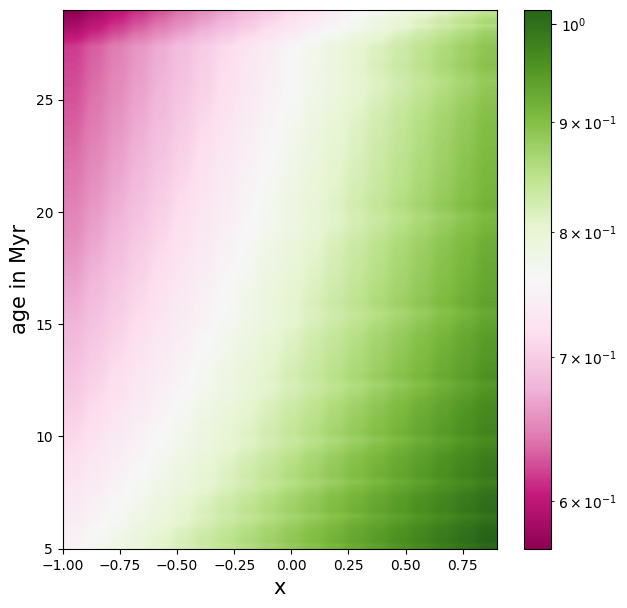

In [70]:
#all the ages that we will test
ages=np.unique(isochrones['logAge'])

#distance
dmin,dmax,step=-1,1,0.1
xs = np.arange(dmin,dmax,step)

#define an array to save the root-mean-square deviation values
rmsd=np.zeros(shape=(len(ages),len(xs)))
for i in range(len(ages)):
    age=ages[i]
    for j in range(len(xs)):

        

        isochrone=isochrones[isochrones['logAge'] == age][0:N]
        col_iso = isochrone['Bmag'] - isochrone['Vmag'] #color isochrone
        mag_iso = isochrone['Bmag'] 
        line = LineString(np.asarray([col_iso,mag_iso]).T) #Representation of the isochrone as a continuous line

        ## data
        d=np.empty(len(m29))
        w=np.empty(len(m29))
        for k in range(len(m29)):
            if k not in m29.index : continue 

            col_data=m29['mB'][k] - m29['mV'][k]
            mag_data=m29['MB'][k] + xs[j]
            

            point=Point(col_data,mag_data)
            d[k] = point.distance(line) #shortest distance of the point to the line of the isochrone

            #using inverse of uncertainties as weights
            mag_err = m29["MB_err"][k]
            col_err = m29["BV_err"][k]
            w[k] = 1.0 /np.sqrt (mag_err**2 + col_err**2)  

        rmsd[i,j]=np.sqrt( np.average(d**2,weights=w)  )
        #print(rmsd[i,j])
print(rmsd.shape)
fig,ax = plt.subplots(figsize=(7,7))
pos=ax.imshow(rmsd,cmap='PiYG', norm=LogNorm(),origin='lower',
               extent=[xs[0],xs[-1],10**ages[0]/1e6,10**ages[-1]/1e6],aspect='auto')
fig.colorbar(pos, ax=ax)#,format= "%d")

#Find the grid position of the minimum rmsd
minrmsd_pos=np.unravel_index(rmsd.argmin(), rmsd.shape)
print(np.nanmin(rmsd),minrmsd_pos)
print("*** Best fit model: age = ", np.round(10**ages[minrmsd_pos[0]]/1e6),'Myr; x=',xs[minrmsd_pos[1]],'pc')
best_age=ages[minrmsd_pos[0]]
best_dist=xs[minrmsd_pos[1]]
plt.xlabel('x',fontsize=15)
plt.ylabel('age in Myr',fontsize=15)

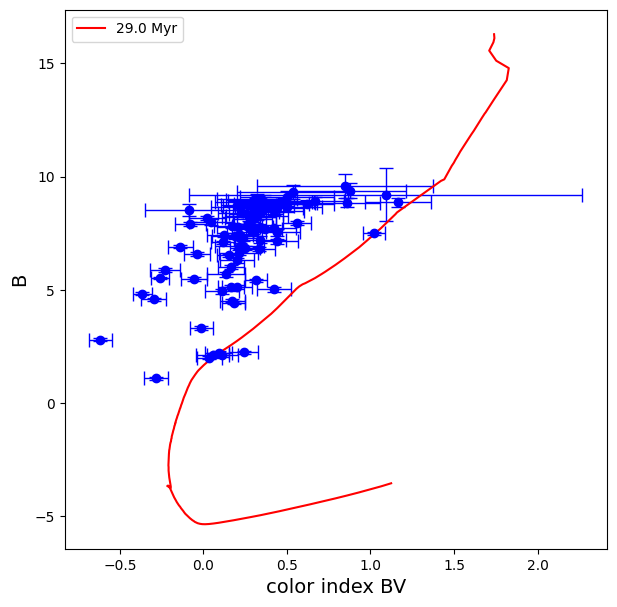

In [71]:
fig = plt.figure(figsize=(7,7))
plt.errorbar(
    x=m29["BV"],
    y=m29["MB"],
    xerr=m29["BV_err"],
    yerr=m29["mB_err"],
    fmt='o', ecolor='blue', elinewidth=1, capsize=5,c='blue'
)

plt.xlabel('color index BV',fontsize=14)
plt.ylabel('B',fontsize=14)

age_1 = isochrones['logAge'] == best_age
plt.plot(isochrones['Bmag'][age_1][0:N] - isochrones['Vmag'][age_1][0:N], isochrones['Bmag'][age_1][0:N],label=str(np.round(10**best_age/1e6))+' Myr',color='red')
plt.legend()



## Fit age of the cluster only (no fitting distances)

*** Best fit model: age = 28.250100684415916 Myr


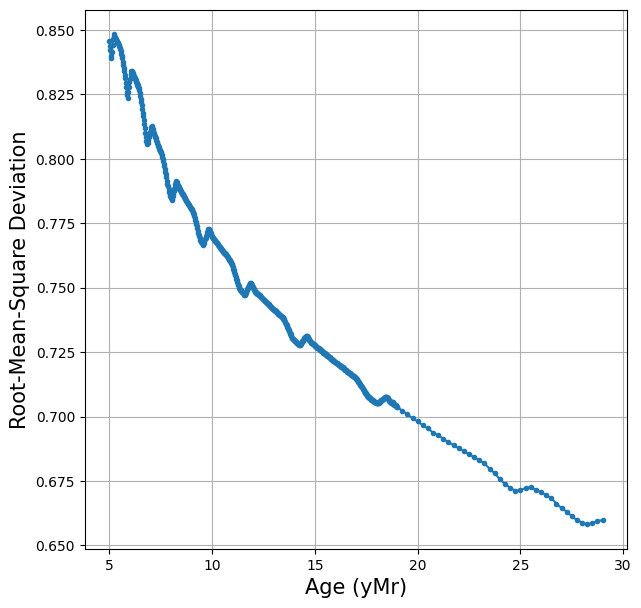

In [72]:
# All the ages that we will test
ages = np.unique(isochrones['logAge'])


rmsd = np.zeros(shape=(len(ages)))

for i in range(len(ages)):
    age = ages[i]

    # Model
    isochrone = isochrones[isochrones['logAge'] == age]
    col_iso = isochrone['Bmag'] - isochrone['Vmag']  # Color isochrone
    mag_iso = isochrone['Bmag']  # Magnitude isochrone

    line = LineString(np.asarray([col_iso, mag_iso]).T)  # Representation of the isochrone as a continuous line

    # Data
    d = np.empty(len(m29))
    for k in range(len(m29)):
        if k not in m29.index : continue 
        col_data = m29['BV'][k]
        mag_data = m29['MB'][k]
        point = Point(col_data, mag_data)
        d[k] = point.distance(line)  # Shortest distance of the point to the line of the isochrone

    rmsd[i] = np.sqrt(np.nanmean(d) ** 2)

# Plot RMSD values against ages
plt.figure(figsize=(7, 7))
plt.plot(10 ** ages / 1e6, rmsd, marker='.', linestyle='-')
plt.xlabel('Age (yMr)', fontsize=15)
plt.ylabel('Root-Mean-Square Deviation', fontsize=15)
plt.grid(True)

# Find the age corresponding to the minimum RMSD
best_age = 10 ** ages[rmsd.argmin()] / 1e6
print(f"*** Best fit model: age = {best_age} Myr")

### Uncertainties Fit age of the cluster only (no fitting distances)

*** Best fit model: age = 29.00013369054067 Myr


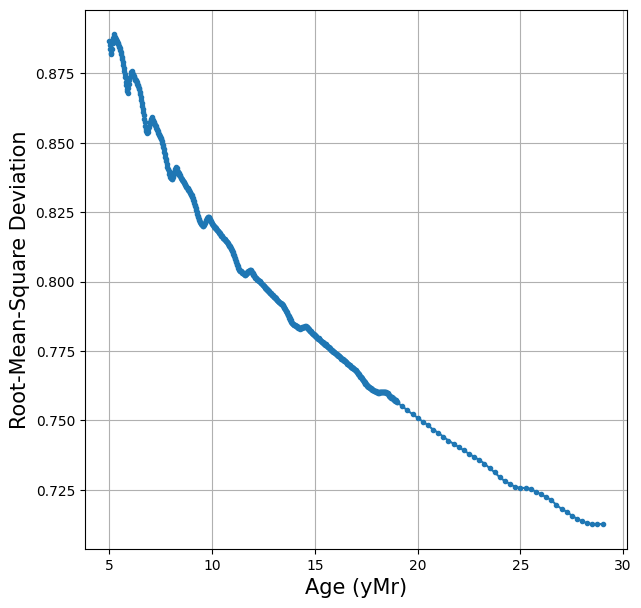

In [73]:

# All the ages that we will test
ages = np.unique(isochrones['logAge'])


rmsd = np.zeros(shape=(len(ages)))

for i in range(len(ages)):
    age = ages[i]

    # Model
    isochrone = isochrones[isochrones['logAge'] == age]
    col_iso = isochrone['Bmag'] - isochrone['Vmag']  # Color isochrone
    mag_iso = isochrone['Bmag']  # Magnitude isochrone

    line = LineString(np.asarray([col_iso, mag_iso]).T)  # Representation of the isochrone as a continuous line

    # Data
    d = np.empty(len(m29))
    w=np.empty(len(m29))

    for k in range(len(m29)):
        if k not in m29.index : continue 
        col_data = m29['BV'][k]
        mag_data = m29['MB'][k]
        point = Point(col_data, mag_data)
        d[k] = point.distance(line)  # Shortest distance of the point to the line of the isochrone
        
        
        mag_err = m29["MB_err"][k]
        col_err = m29["BV_err"][k]
        w[k] = 1.0 / np.sqrt(mag_err**2 + col_err**2) 

    rmsd[i]=np.sqrt( np.average(d**2,weights=w)  )

# Plot RMSD values against ages
plt.figure(figsize=(7, 7))
plt.plot(10 ** ages / 1e6, rmsd, marker='.', linestyle='-')
plt.xlabel('Age (yMr)', fontsize=15)
plt.ylabel('Root-Mean-Square Deviation', fontsize=15)
plt.grid(True)

# Find the age corresponding to the minimum RMSD
best_age = 10 ** ages[rmsd.argmin()] / 1e6
print(f"*** Best fit model: age = {best_age} Myr")